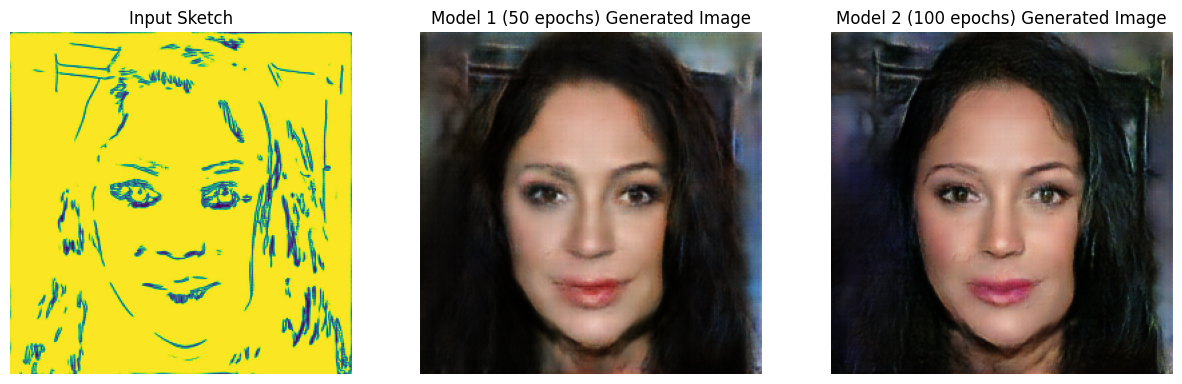

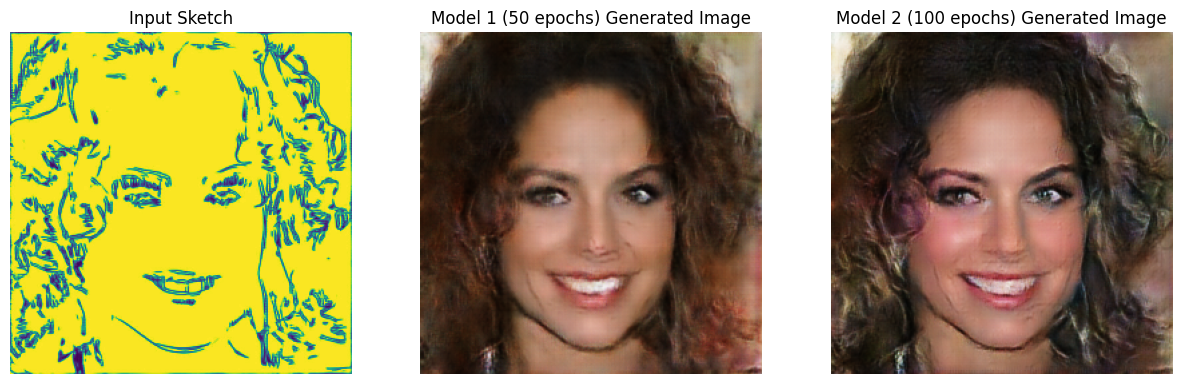

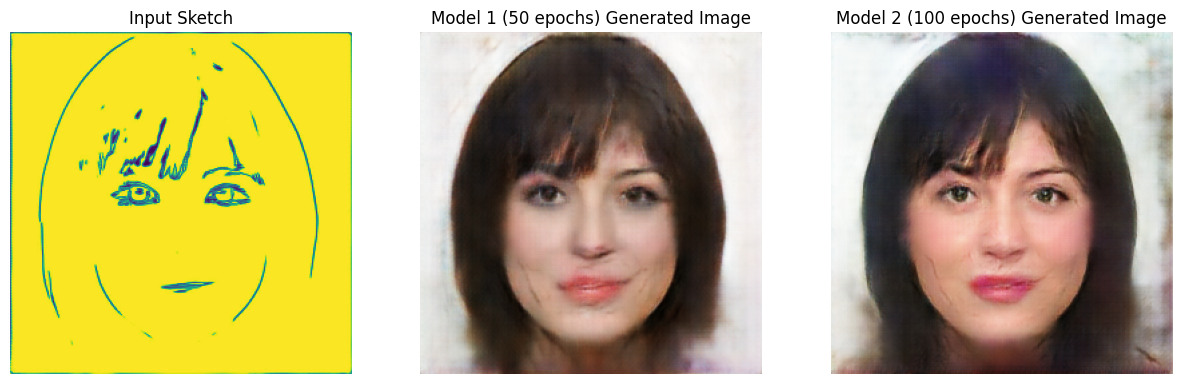

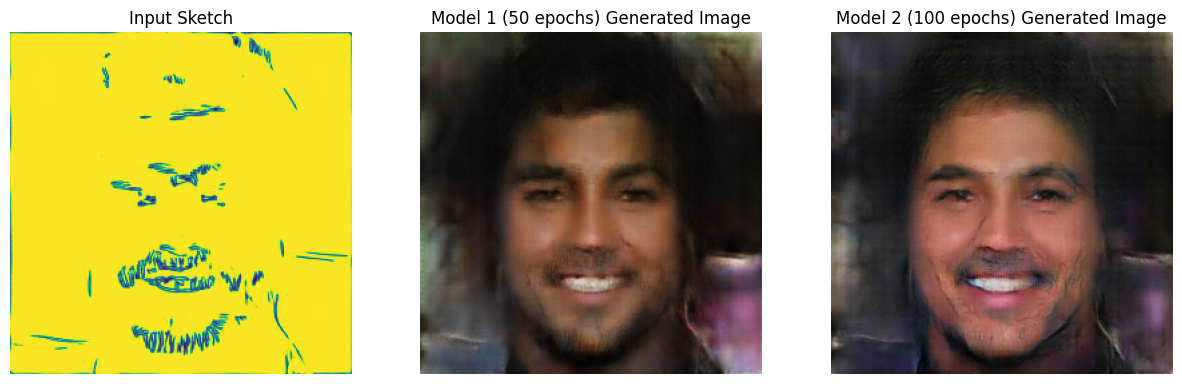

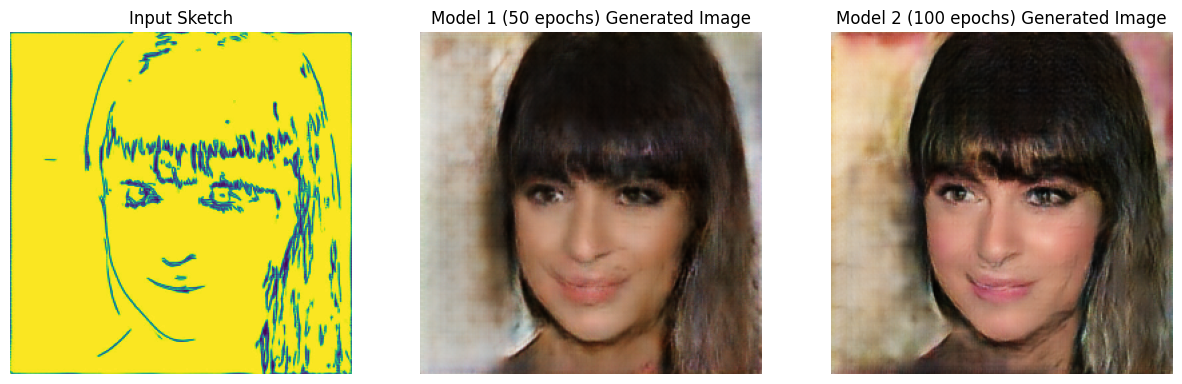

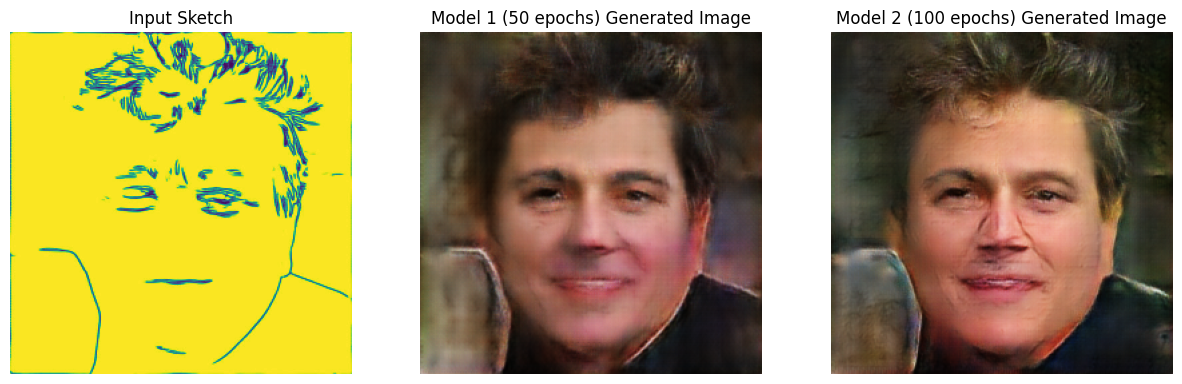

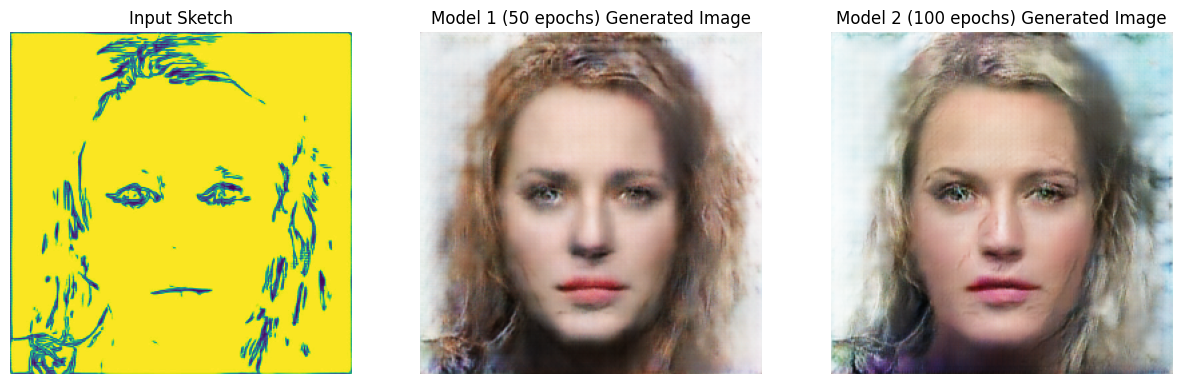

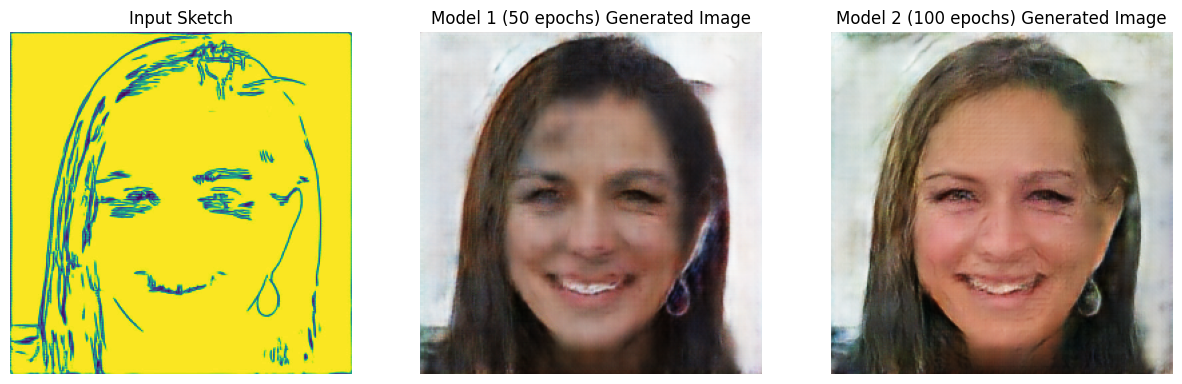

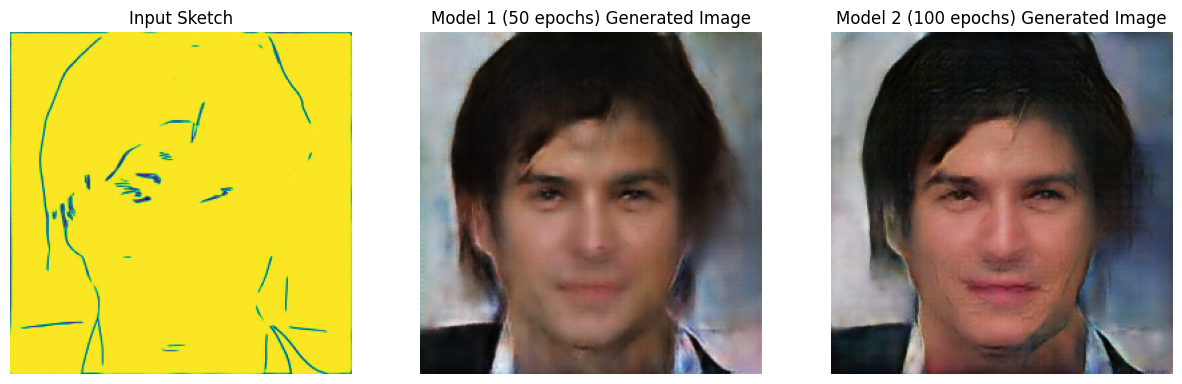

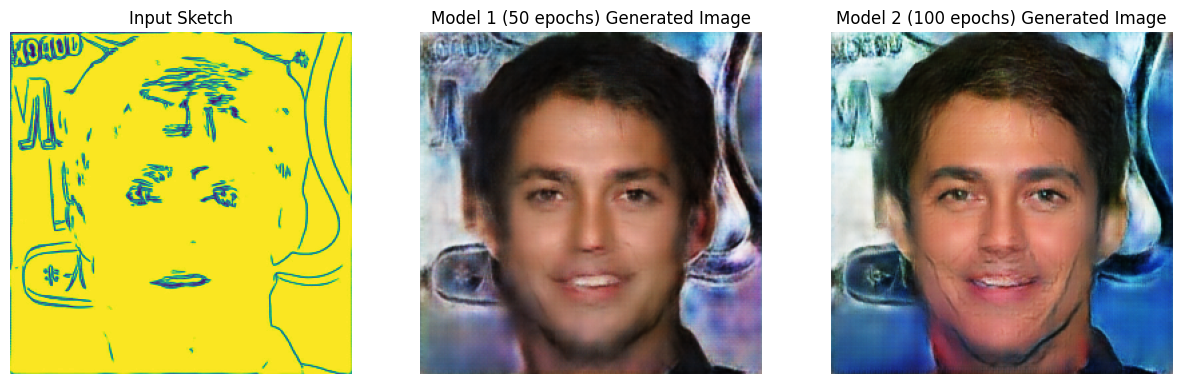

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib
import os
import random

# Constants
IMAGE_SIZE = (256, 256)
SAVE_DIR = './generated_images/'  # Directory to save generated images

# Create directory if it doesn't exist
os.makedirs(SAVE_DIR, exist_ok=True)

# Load and preprocess a new sketch image
def load_and_preprocess_sketch(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5  # Normalize to [-1, 1]
    img = tf.image.rgb_to_grayscale(img)  # Convert to grayscale
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Create the generator model (assumed downsample and upsample are predefined functions)
def make_generator_model():
    inputs = tf.keras.layers.Input(shape=[256, 256, 1])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

# Function to load a model from a given checkpoint directory
def load_model_from_checkpoint(checkpoint_dir):
    generator = make_generator_model()
    checkpoint = tf.train.Checkpoint(generator=generator)
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir)).expect_partial()
    return generator

# Function to generate and compare images from two models
def generate_and_compare_images(test_sketch_dir, model1, model2, num_images=10):
    sketch_paths = list(pathlib.Path(test_sketch_dir).glob('*.jpg'))  # Adjust this pattern if necessary

    # Select 10 random images
    random_sketch_paths = random.sample(sketch_paths, num_images)

    for i, sketch_path in enumerate(random_sketch_paths):
        sketch_image = load_and_preprocess_sketch(str(sketch_path))
        
        # Generate images from both models
        prediction_model1 = model1(sketch_image, training=False)
        prediction_model2 = model2(sketch_image, training=False)

        # Save generated images
        generated_image_model1 = prediction_model1[0] * 0.5 + 0.5  # Rescale to [0, 1]
        generated_image_model2 = prediction_model2[0] * 0.5 + 0.5  # Rescale to [0, 1]
        plt.imsave(os.path.join(SAVE_DIR, f'generated_image_model1_{i+1+10}.png'), generated_image_model1.numpy())
        plt.imsave(os.path.join(SAVE_DIR, f'generated_image_model2_{i+1}.png'), generated_image_model2.numpy())

        # Display the sketch and generated images side by side
        plt.figure(figsize=(15, 10))
        display_list = [sketch_image[0], prediction_model1[0], prediction_model2[0]]
        title = ['Input Sketch', 'Model 1 (50 epochs) Generated Image', 'Model 2 (100 epochs) Generated Image']

        for j in range(3):
            plt.subplot(1, 3, j+1)
            plt.title(title[j])
            plt.imshow(display_list[j] * 0.5 + 0.5)  # Rescale to [0, 1]
            plt.axis('off')
        plt.savefig(os.path.join(SAVE_DIR, f'comparison_plot_{i+1}.png'))  # Save the plot as PNG
        plt.show()

# Load the two models from their respective checkpoints
model1_checkpoint_dir = '/kaggle/input/sketch2face/tensorflow2/default/1'
model2_checkpoint_dir = '/kaggle/input/sketch2face/tensorflow2/default/3'

model1 = load_model_from_checkpoint(model1_checkpoint_dir)
model2 = load_model_from_checkpoint(model2_checkpoint_dir)

# Example usage: Generate and compare 10 random images from the test dataset
test_sketch_directory = '/kaggle/input/person-face-sketches/test/sketches'  # Replace with the path to your test sketches
generate_and_compare_images(test_sketch_directory, model1, model2, num_images=10)
